In [36]:
import keras 
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import os
import matplotlib.pyplot as plt

In [37]:
# lets split the data and handle 
fmnist_dataset=tf.keras.datasets.fashion_mnist.load_data()
(x_train_full,y_train_full),(x_test,y_test)=fmnist_dataset

In [38]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(x_train_full,y_train_full,
                                                 random_state=42,
                                                 stratify=y_train_full,
                                                 test_size=0.3)

In [39]:
# lets reshape
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)

In [40]:
y_valid=y_valid.reshape(-1,1)

In [42]:
print(x_train.shape,y_train.shape)

(42000, 28, 28) (42000, 1)


In [43]:
#let change the data type into tenorflow dataset
train_set=tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(len(x_train))
valid_set=tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
test_set=tf.data.Dataset.from_tensor_slices((x_test,y_test))

# the protocol-buffer and TFRecord part

In [44]:
from tensorflow.train import BytesList,FloatList,Int64List #data types
from tensorflow.train import Example,Features,Feature

In [45]:
def create_example(image,label):
    image_data=tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image":Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label":Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

In [46]:
for image,label in train_set.take(1):
    print(create_example(image,label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\00

In [54]:
# the tfrecord part
from contextlib import ExitStack

def write_tfrecords(name,dataset,n_shards=10):
    paths=["{}.tfrecord -{:05d}--of-{:05d}".format(name,index,n_shards) for index in range(n_shards)]
    with ExitStack() as stack:
        writers=[stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index,(image,label) in dataset.enumerate():
            shard=index%n_shards
            example=create_example(image,label)
            writers[shard].write(example.SerializeToString())
    return paths

In [57]:
train_filepaths=write_tfrecords("my_fashion_mnist.train",train_set)
valid_filepaths=write_tfrecords("my_fashion_mnist.valid",valid_set)
test_filepaths=write_tfrecords("my_fashion_mnist.test",test_set)

In [71]:
# preprocess the tfrecords
def preprocess(tfrecords):
    #this is for de-serialization 
    feature_discriptions={
        "image":tf.io.FixedLenFeature([],tf.string,default_value=""), #the number is stated as string here
        "label":tf.io.FixedLenFeature([],tf.int64,default_value=-1)
    }
    example=tf.io.parse_single_example(tfrecords,feature_discriptions)
    image=tf.io.parse_tensor(example["image"],out_type=tf.uint8)
    image=tf.reshape(image,[28,28])
    return image,example["label"]


In [72]:
# for shuffling the dataset
def mnist_dataset(filepath,n_read_threads=5,shuffle_buffer_size=None,n_parse_threads=5,batch_size=32,cache=True):
    dataset=tf.data.TFRecordDataset(filepath,num_parallel_reads=n_read_threads)
    if cache:
        dataset=dataset.cache()
    if shuffle_buffer_size:
        dataset.shuffle(shuffle_buffer_size)
    dataset=dataset.map(preprocess,num_parallel_calls=n_parse_threads)
    dataset=dataset.batch(batch_size)
    return dataset.prefetch(1)

In [73]:
train_set=mnist_dataset(train_filepaths,shuffle_buffer_size=60000)
valid_set=mnist_dataset(valid_filepaths)
test_set=mnist_dataset(test_filepaths)

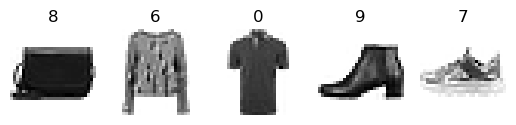

In [74]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [75]:
#this is local-standardizer
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [77]:
standardization = Standardization(input_shape=[28, 28])

In [78]:
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

In [79]:
model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [80]:
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5
1313/1313 [==============================] - 55s 31ms/step - loss: 0.4817 - accuracy: 0.8353 - val_loss: 0.3925 - val_accuracy: 0.8699
Epoch 2/5
1313/1313 [==============================] - 24s 18ms/step - loss: 0.3542 - accuracy: 0.8732 - val_loss: 0.3688 - val_accuracy: 0.8753
Epoch 3/5
1313/1313 [==============================] - 15s 11ms/step - loss: 0.3118 - accuracy: 0.8863 - val_loss: 0.3532 - val_accuracy: 0.8803
Epoch 4/5
1313/1313 [==============================] - 19s 15ms/step - loss: 0.2798 - accuracy: 0.8983 - val_loss: 0.3618 - val_accuracy: 0.8823
Epoch 5/5
1313/1313 [==============================] - 20s 15ms/step - loss: 0.2595 - accuracy: 0.9064 - val_loss: 0.3554 - val_accuracy: 0.8858
